##### Sami Ramzi Chibane © 

# L'anayse des réseaux routiers avec "Momepy"

##### Dans ce carnet, nous allons nous intéresser à Amsterdam, la Capitale des Pays-Bas. Nous récupérons son réseau "pédestre" depuis OSM à l'aide du package OSMnx. Le but de ce cahier est d'illustrer comment mesurer différentes centralités à l'aide de "Momepy".
##### L'évaluation de la centralité multiple (MCA) "Multiple Centrality Assessment " est une approche d'analyse du réseau routier développée par Porta et Latora (2006). Son objectif principal est de comprendre la structure des réseaux de rues de nos villes du point de vue de l'importance et de la position de chaque rue "edge"/intersection "node" au sein de l'ensemble du réseau exprimée par diverses mesures de centralités. "Momepy" peut effectuer tous les types d'analyses de centralité basées sur MCA

In [1]:
import geopandas as gpd
import momepy
import osmnx as ox
import matplotlib.pyplot as plt

In [2]:
streets_graph = ox.graph_from_place('Troyes, France', network_type='walk')
streets_graph = ox.projection.project_graph(streets_graph)

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


##### Le script ci-dessus a téléchargé le réseau depuis OSM et l'a projeté. À ce stade, street_graph est un objet networkX Graph, similaire à celui que nous utiliserons dans "Momepy". En théorie, vous pouvez l'utiliser directement. Toutefois, lors de la conversion d'un GeoDataFrame en réseau à l'aide de "Momepy", assurez-vous que tous les attributs sont définis et compatibles avec les fonctions morphométriques. Je vous recommandons donc d'enregistrer un graphique non orienté dans un GeoDataFrame et de laisser "Momepy" effectuer la conversion vers le graphique.

In [3]:
edges = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

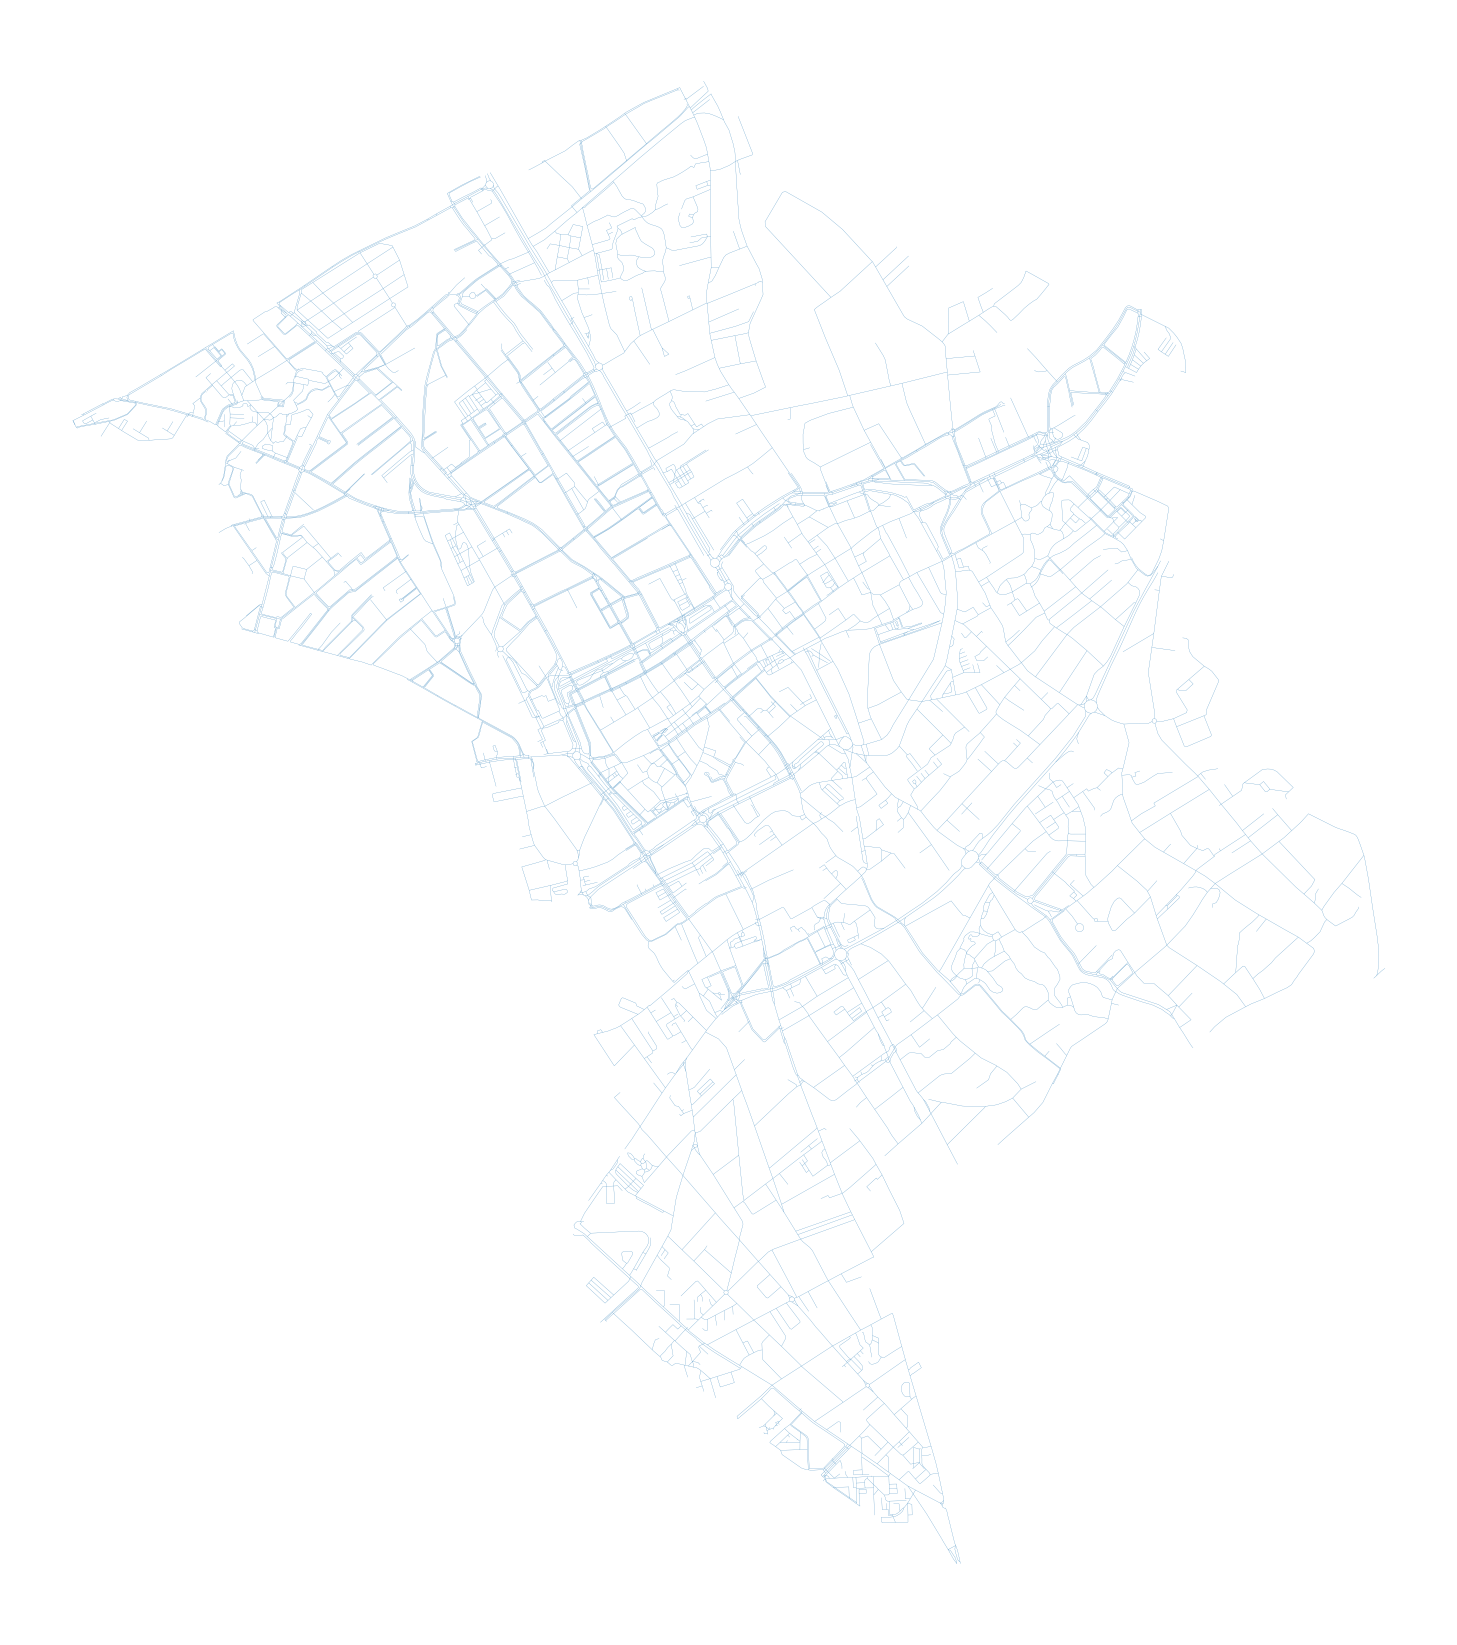

In [4]:
f, ax = plt.subplots(figsize=(30, 30))
edges.plot(ax=ax, linewidth=0.2)
ax.set_axis_off()
plt.show()

##### Pour mesurer la centralité, nous devons convertir  GeoDataFrame en graphe. Pour cela, nous pouvons choisir parmi deux options de représentation des réseaux de rues dans un graphique. La première, et la plus directe, est l'approche primale (Porta et al., 2006) où les rues sont représentées par des rues "edge" de graphe et les intersections par des nœuds "node".

## Graph primap "Primal graph"

##### Nous pouvons générer un networkX.MultiGraph, qui est utilisé dans momepy, en utilisant gdf_to_nx.

In [5]:
primal = momepy.gdf_to_nx(edges, approach='primal')

### Centralité de proximité "Closeness centrality"

##### La centralité de proximité "Closeness centrality" pourrait être simplifiée comme la distance moyenne à tous les autres nœuds à partir de chaque nœud. A ce titre, elle peut être mesurée sur l'ensemble du réseau (Global Closeness Centrality) ou dans une certaine limite seulement (Local Closeness Centrality). Dans cet exemple, je vais développer la proximité locale seulement.

#### Proximité locale "Local closeness"

##### Pour mesurer la proximité_centralité locale, nous devons spécifier un rayon (à quelle distance nous devons aller de chaque nœud). Nous pouvons utiliser la distance topologique (par exemple 5 étapes, puis le rayon = 5) ou la distance métrique (par exemple 400 mètres) - puis le rayon = 400 et la distance = longueur de chaque segment enregistré comme paramètre de chaque bord. Par défaut, momepy enregistre la longueur sous mm_len.
##### Le paramètre de pondération est utilisé pour le calcul de la centralité. Encore une fois, nous pouvons utiliser le poids métrique (en utilisant le même attribut que ci-dessus) ou aucun poids (poids = Aucun). Ou tout autre attribut que nous souhaitons

In [6]:
primal = momepy.closeness_centrality(primal, radius=400, name='closeness400', distance='mm_len', weight='mm_len')

  0%|          | 0/5333 [00:00<?, ?it/s]

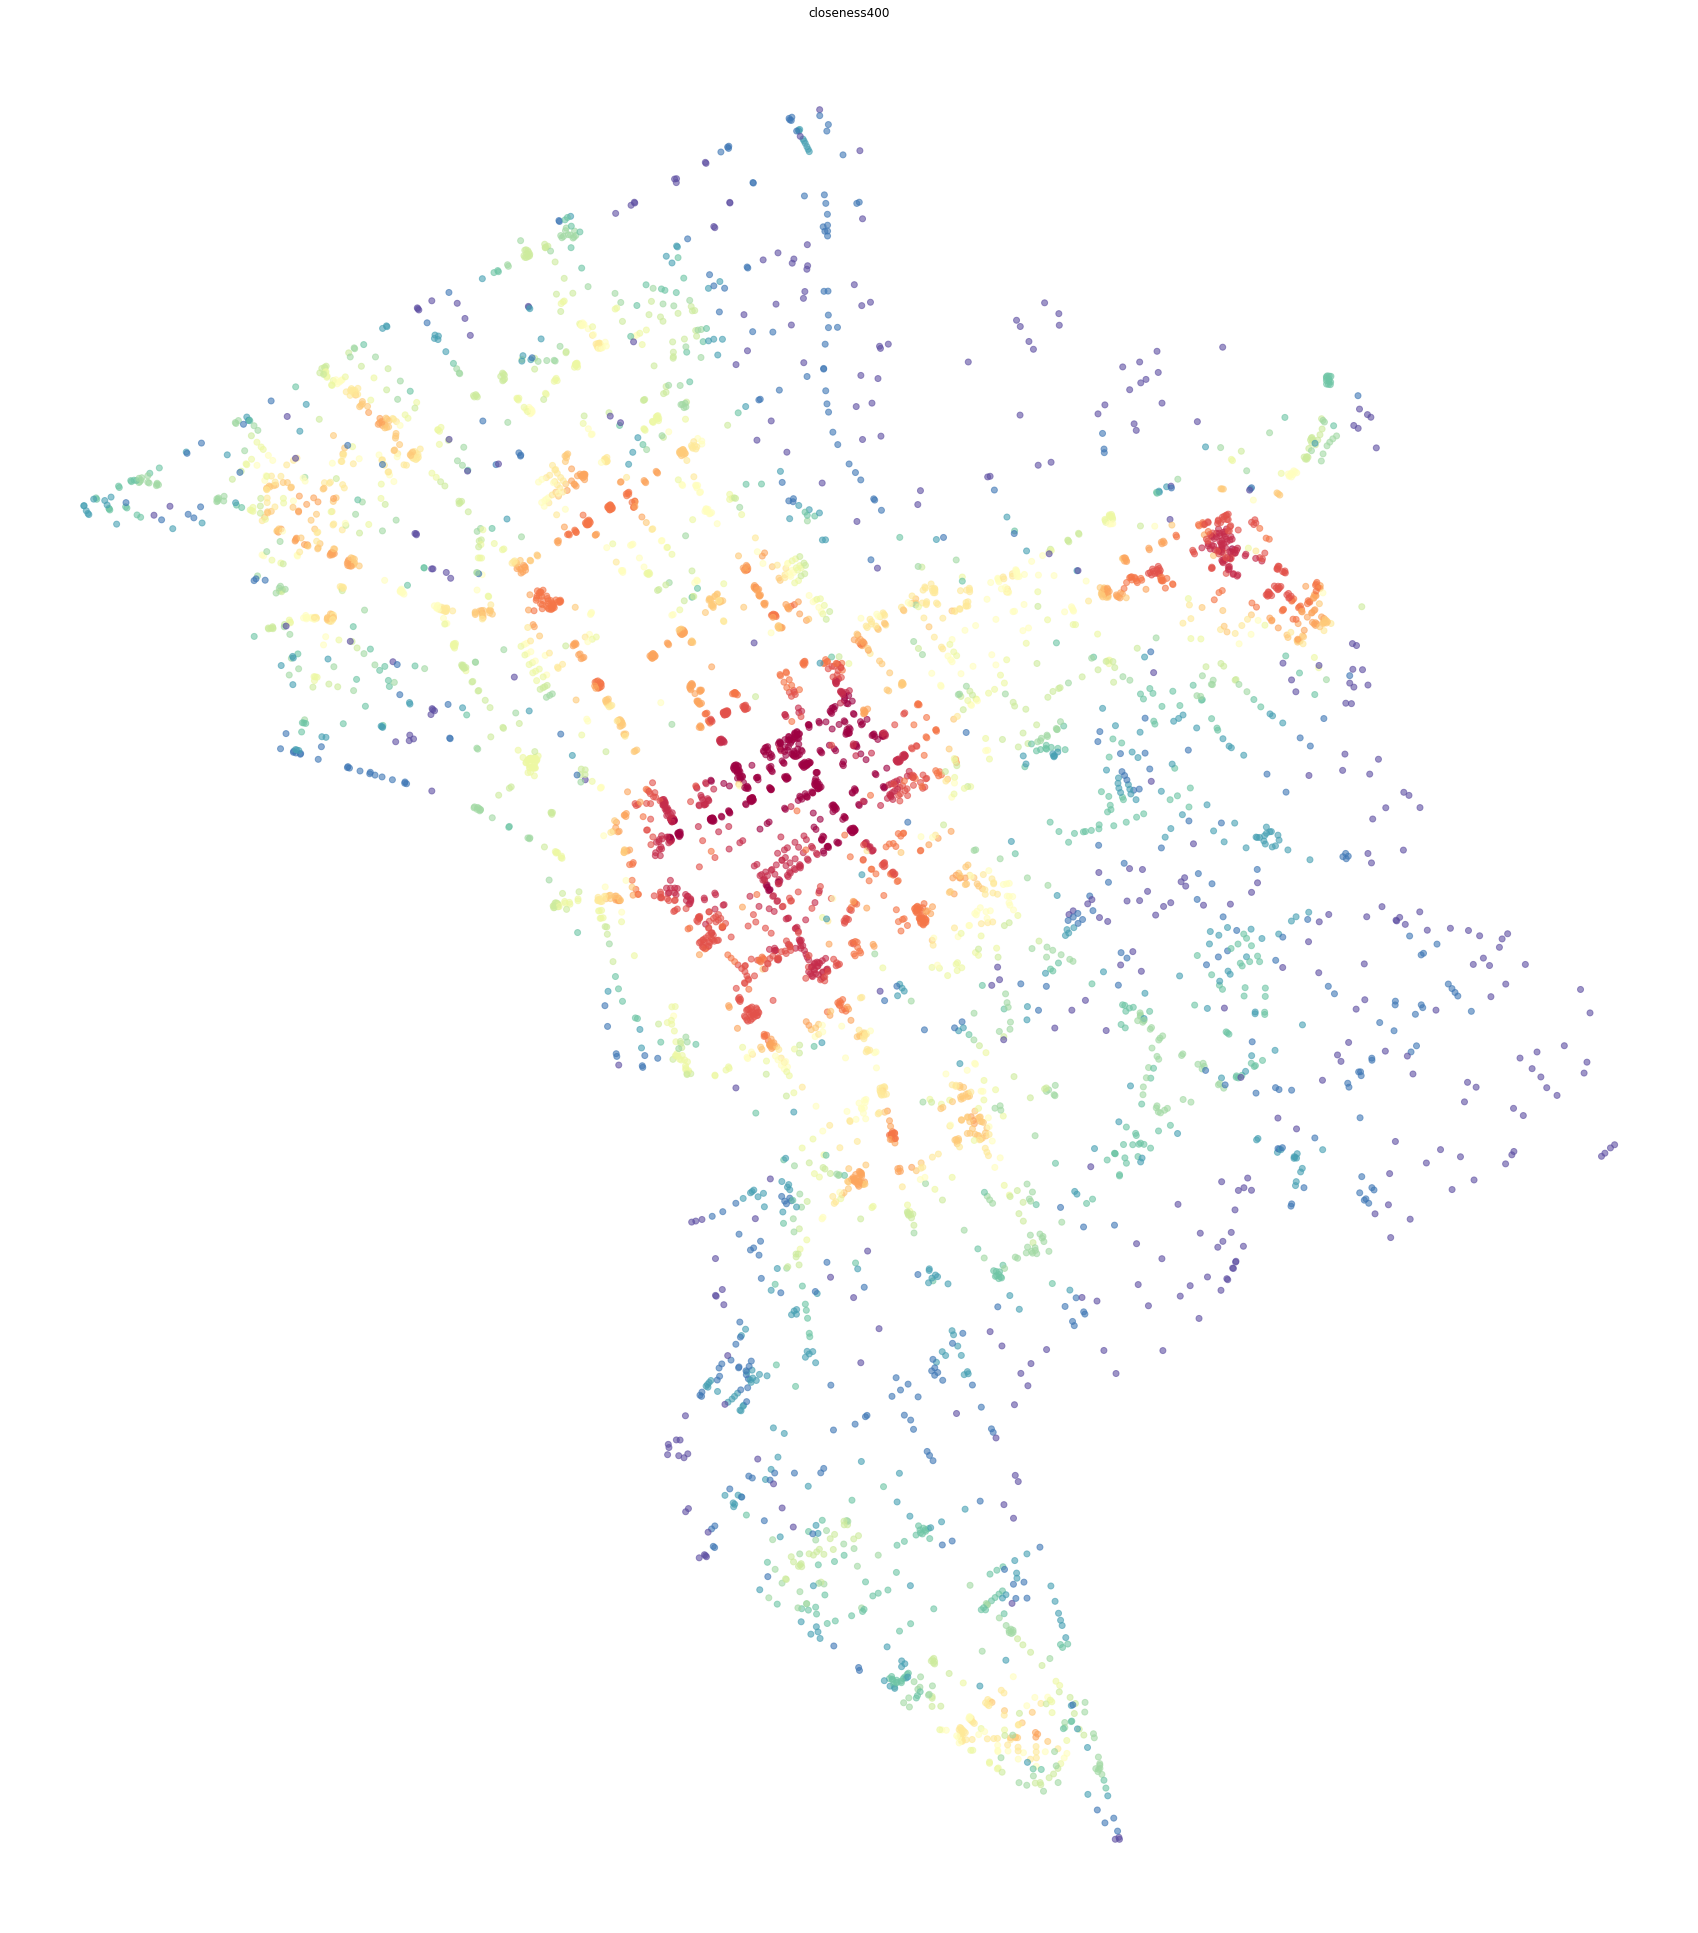

In [7]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(35, 35))
nodes.plot(ax=ax, column='closeness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400')
plt.show()

### Centralité intermédiaire "Betweenness"

##### La centralité intermédiaire "Betweenness" mesure l'importance de chaque nœud ou bord pour se déplacer le long du réseau. Il mesure combien de fois chaque nœud "node"/rue "edge" est utilisé si nous marchons en utilisant les chemins les plus courts de chaque nœud "node" à l'autre.

##### Nous avons deux options pour mesurer l'intermédiarité sur les graphes primaux - sur les nœuds ou sur les rues.

#### Basé sur un nœud "Node-based"

In [8]:
primal = momepy.betweenness_centrality(primal, name='betweenness_metric_n', mode='nodes', weight='mm_len')

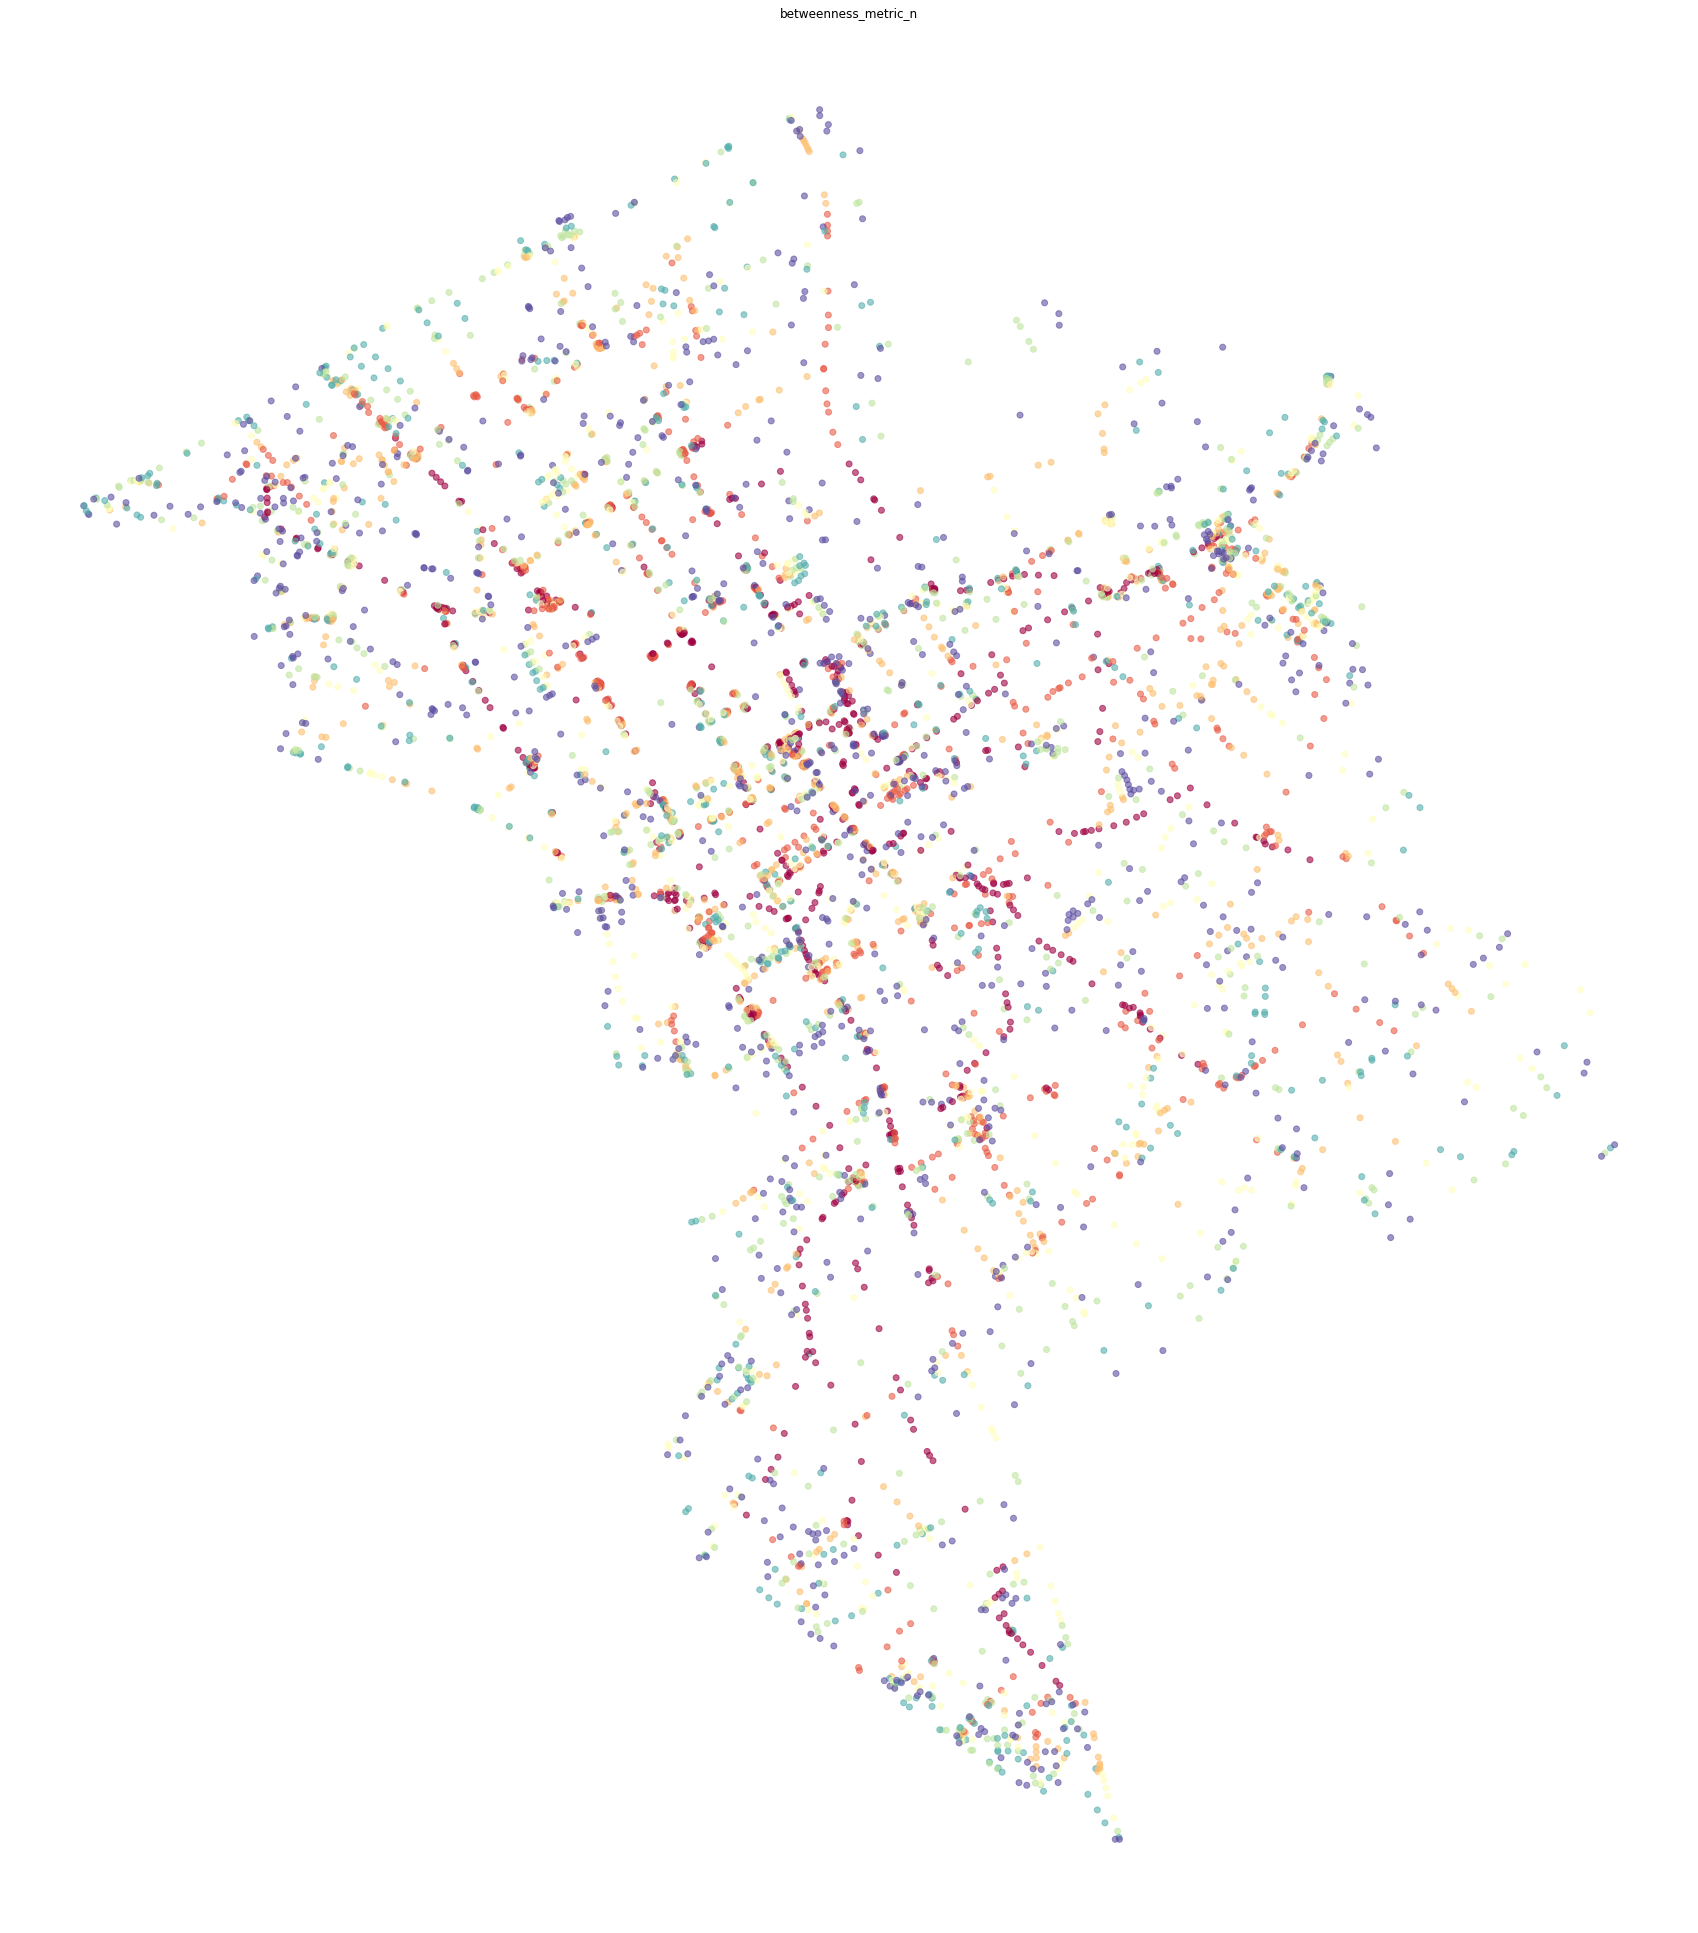

In [9]:
nodes = momepy.nx_to_gdf(primal, lines=False)
f, ax = plt.subplots(figsize=(35, 35))
nodes.plot(ax=ax, column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=7, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweenness_metric_n')
plt.show()

### Continuité dans les réseaux de rues "Continuity in street networks"
##### Momepy permet de déduire la continuité naturelle des réseaux de rues à l'aide de l'algorithme COINS. Le réseau routier est divisé en segments individuels et les angles de déviation entre les segments adjacents sont calculés. Les segments sont ensuite joints en traits continus. Les segments ne seront considérés comme faisant partie du même trait que si l'angle de déviation est supérieur au seuil (valeur par défaut à zéro). Dans le présent exemple, je vais dévelopepr le cas dur réseau pédestre de la ville de Montpellier en France.

In [12]:
streets_graph = ox.graph_from_place('Troyes, France', network_type='walk')
streets_graph = ox.projection.project_graph(streets_graph)

streets = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


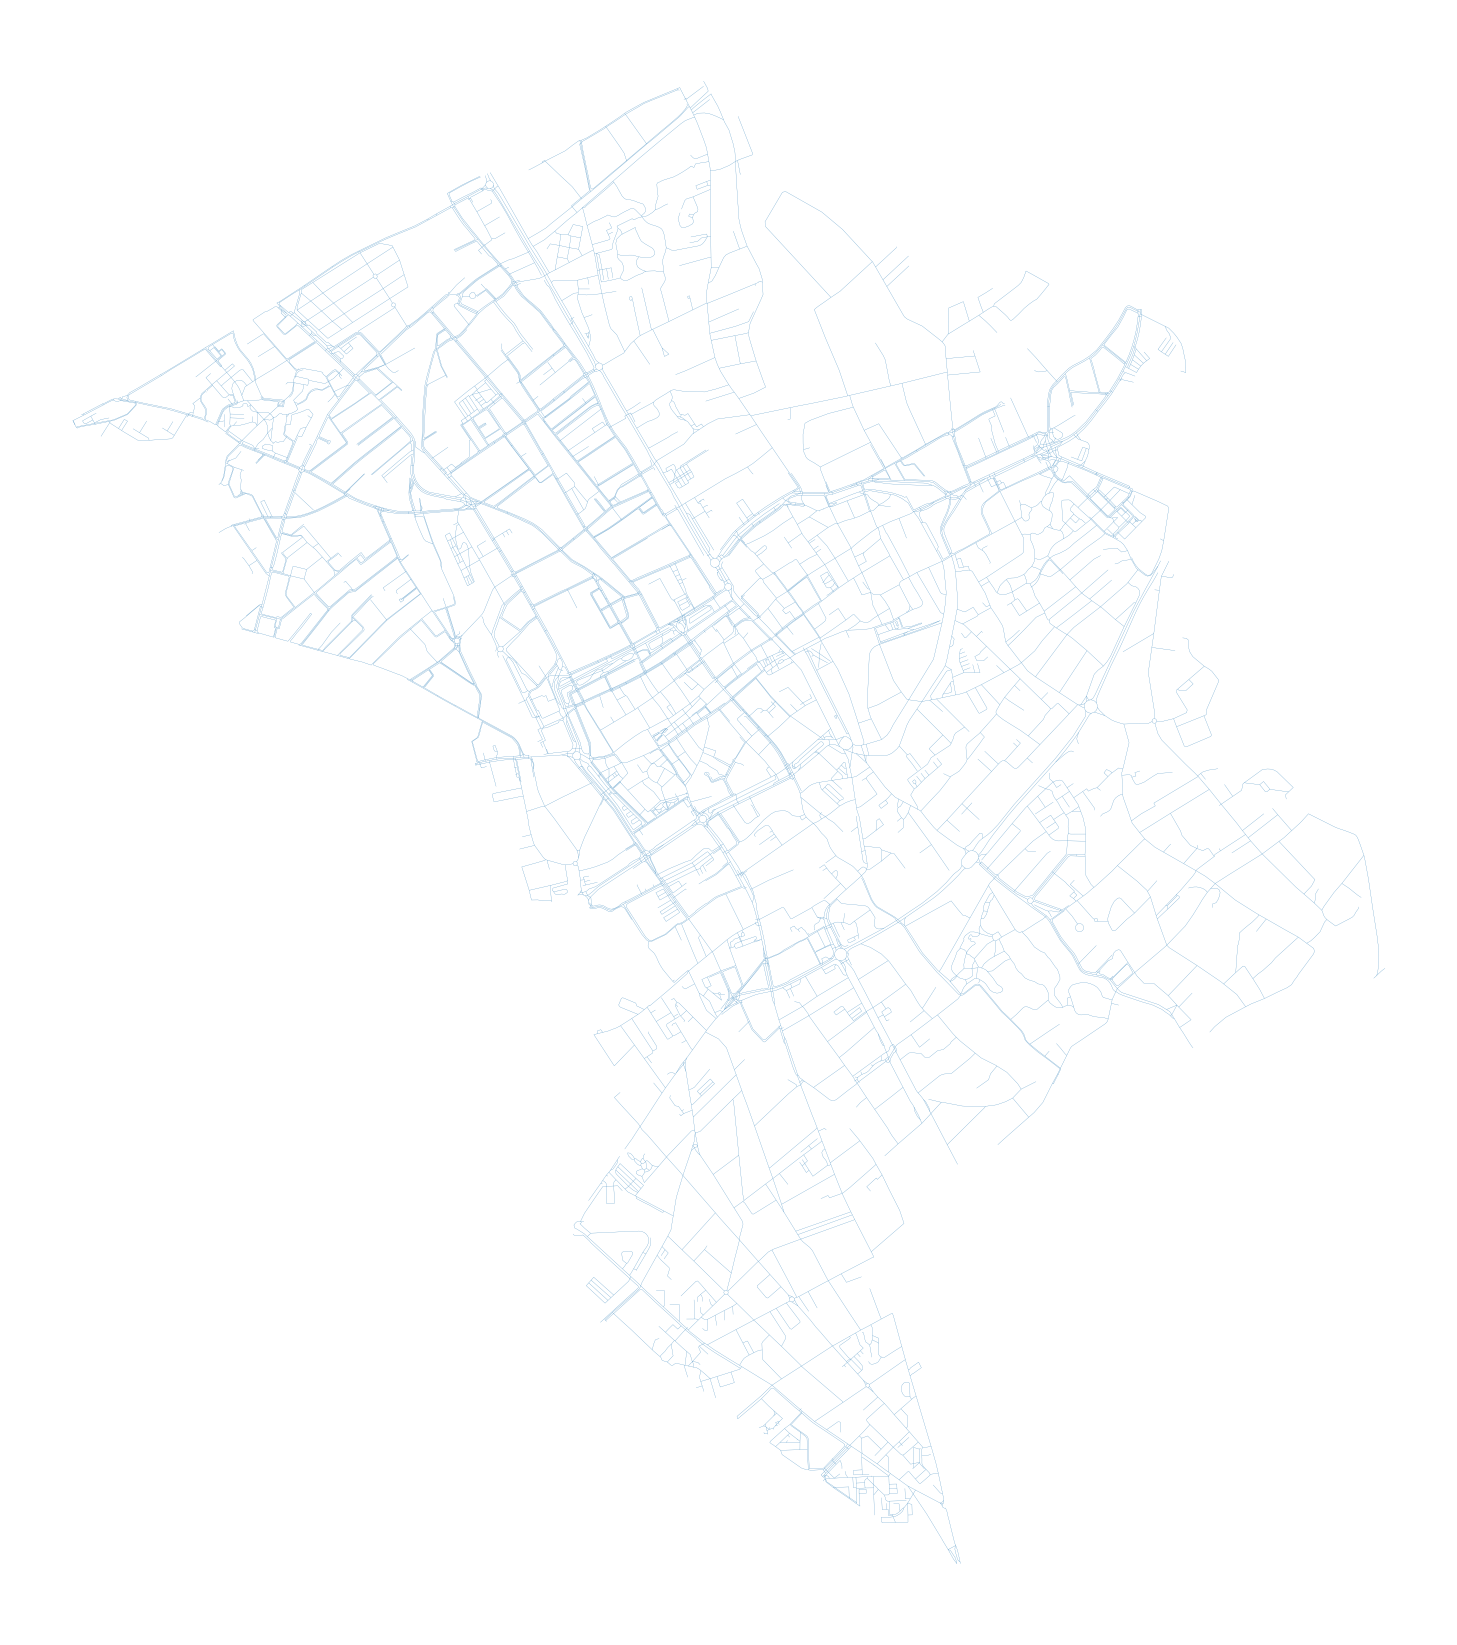

In [13]:
streets.plot(figsize=(30, 30), linewidth=0.2).set_axis_off()

In [14]:
continuity = momepy.COINS(streets)

In [15]:
stroke_gdf = continuity.stroke_gdf()

##### Nous pouvons examiner la hiérarchie des rues basée sur la continuité en fonction de leur longueur totale.

Text(0.5, 1.0, 'Continuité dans les réseaux de rues piétonnes de Montpellier')

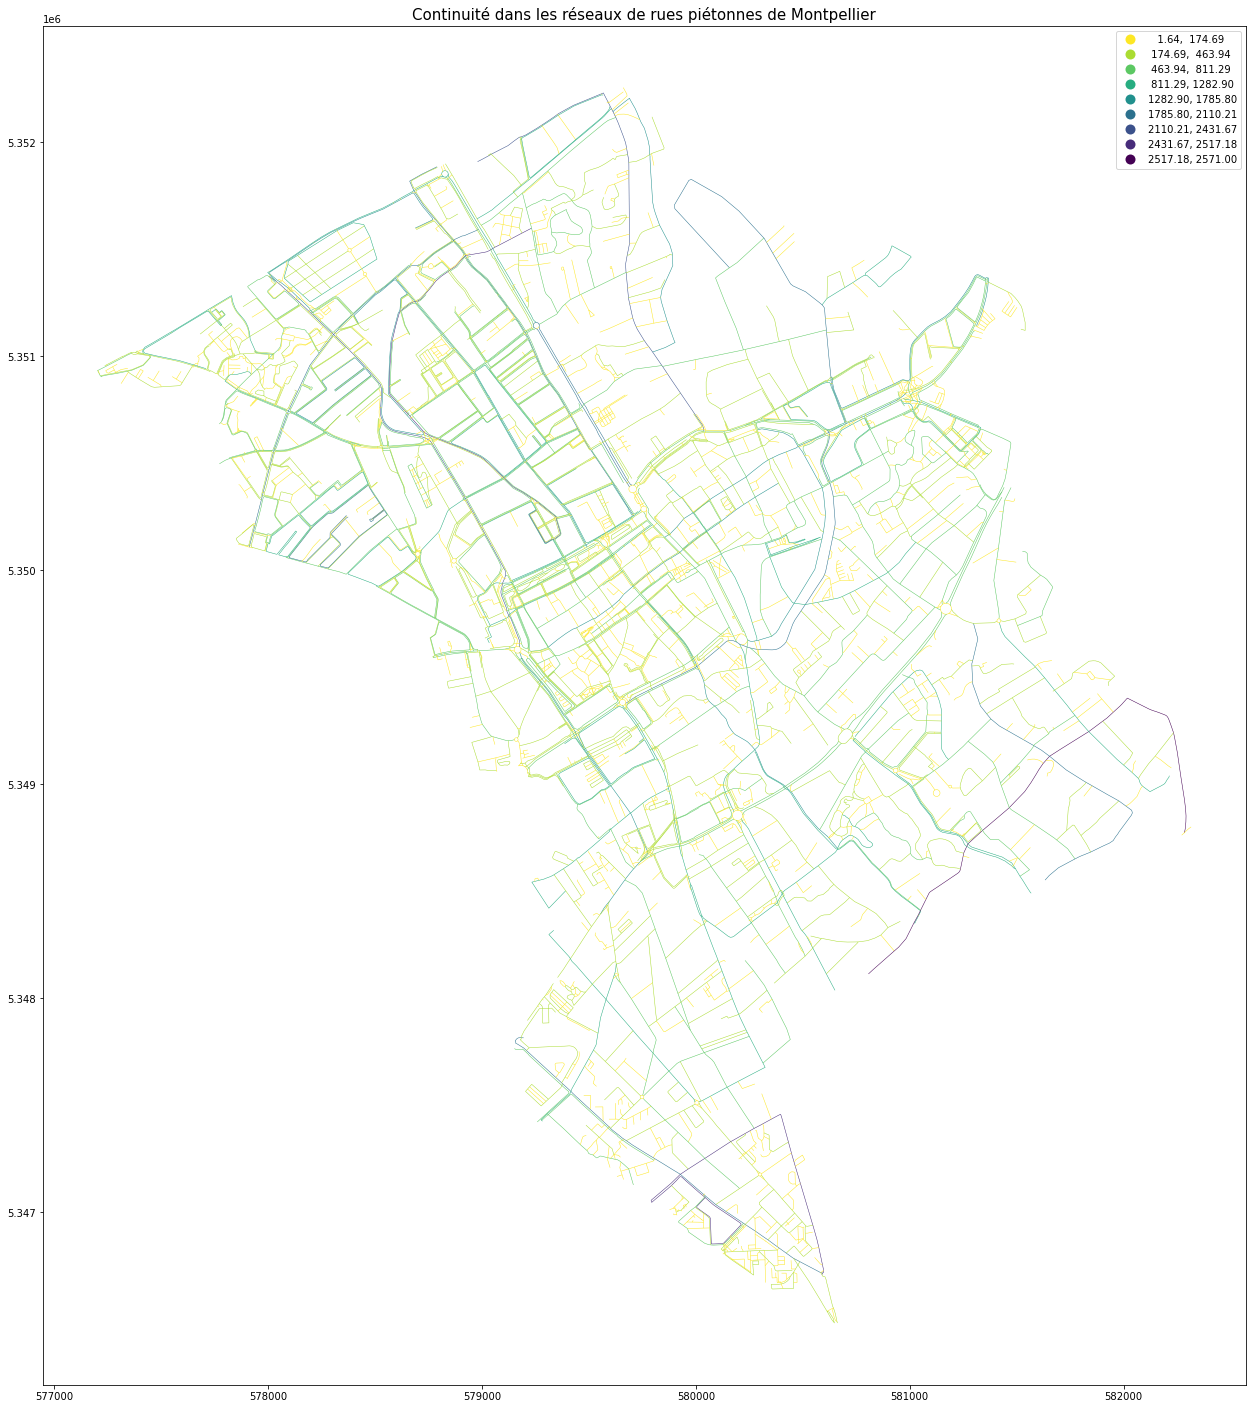

In [16]:
stroke_gdf.plot(stroke_gdf.length,
                figsize=(25, 25),
                cmap="viridis_r",
                linewidth=.5,
                legend=True,
                scheme="headtailbreaks"
               ).set_title("Continuité dans les réseaux de rues piétonnes de Montpellier", fontsize=15)

In [17]:
edges = ox.graph_to_gdfs(streets_graph, nodes=False, edges=True,
                                   node_geometry=False, fill_edge_geometry=True)

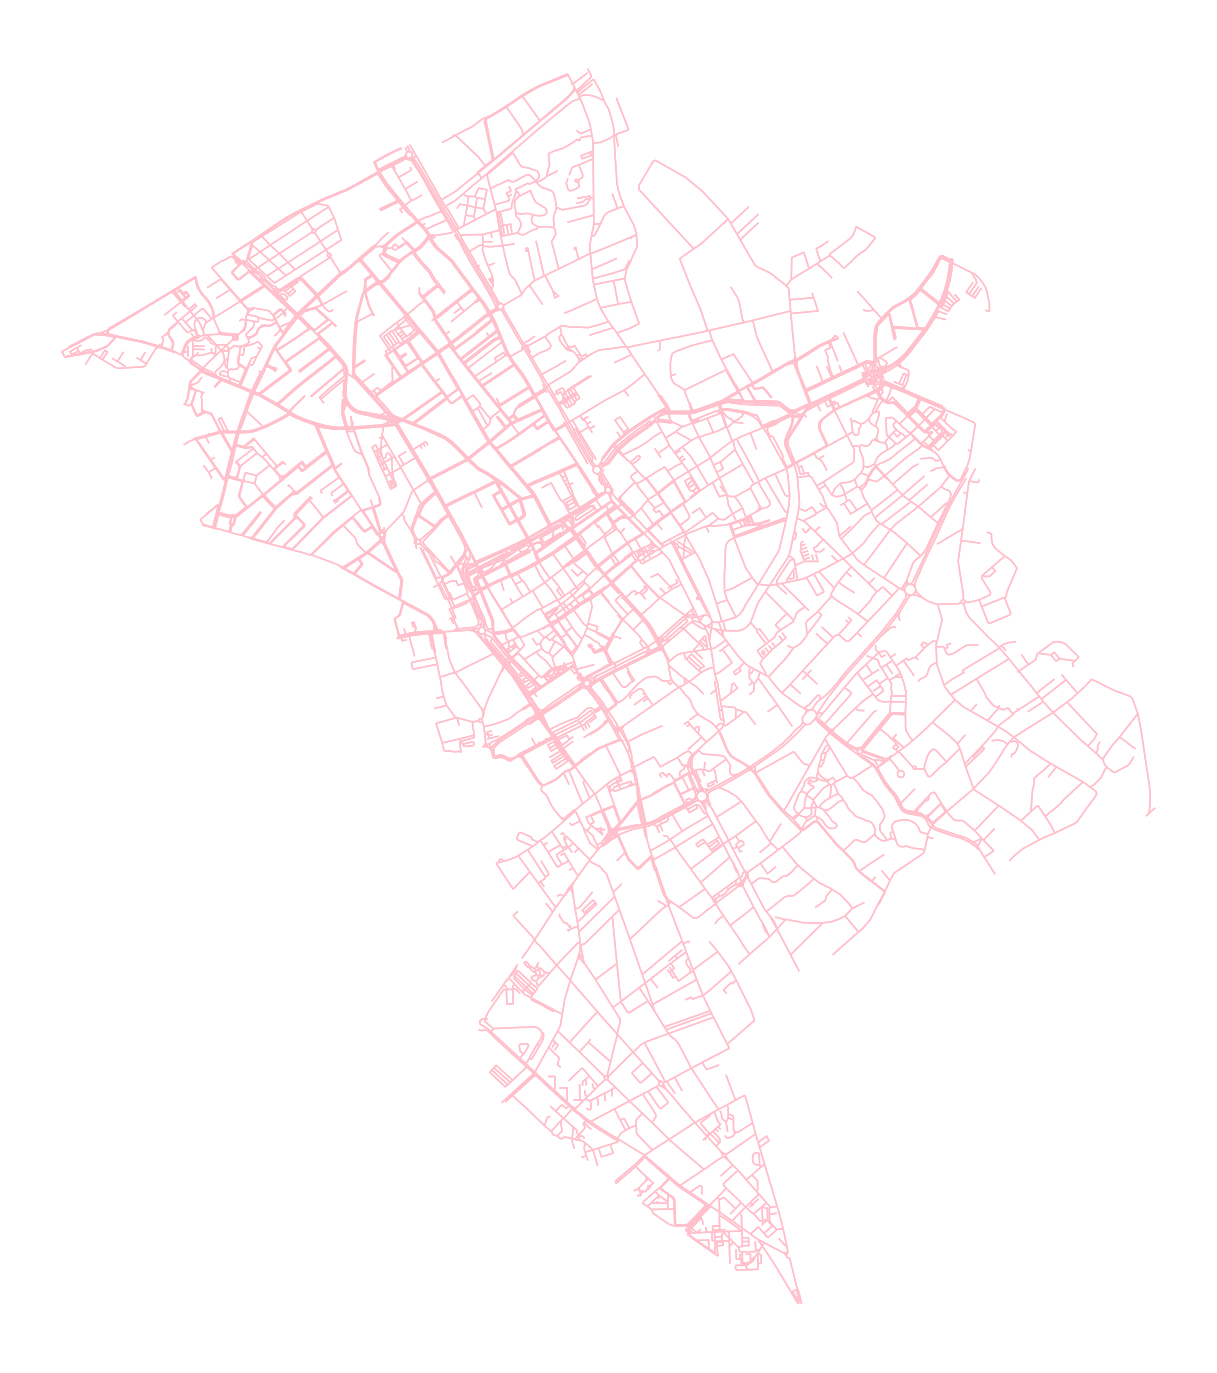

In [18]:
f, ax = plt.subplots(figsize=(25, 25))
edges.plot(ax=ax, color='pink')
ax.set_axis_off()
plt.show()

#### Nous pouvons maintenant calculer la linéarité de chaque segment :

In [19]:
edg_lin = momepy.Linearity(edges)
edges['linearity'] = edg_lin.series

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % k_q, UserWarning)


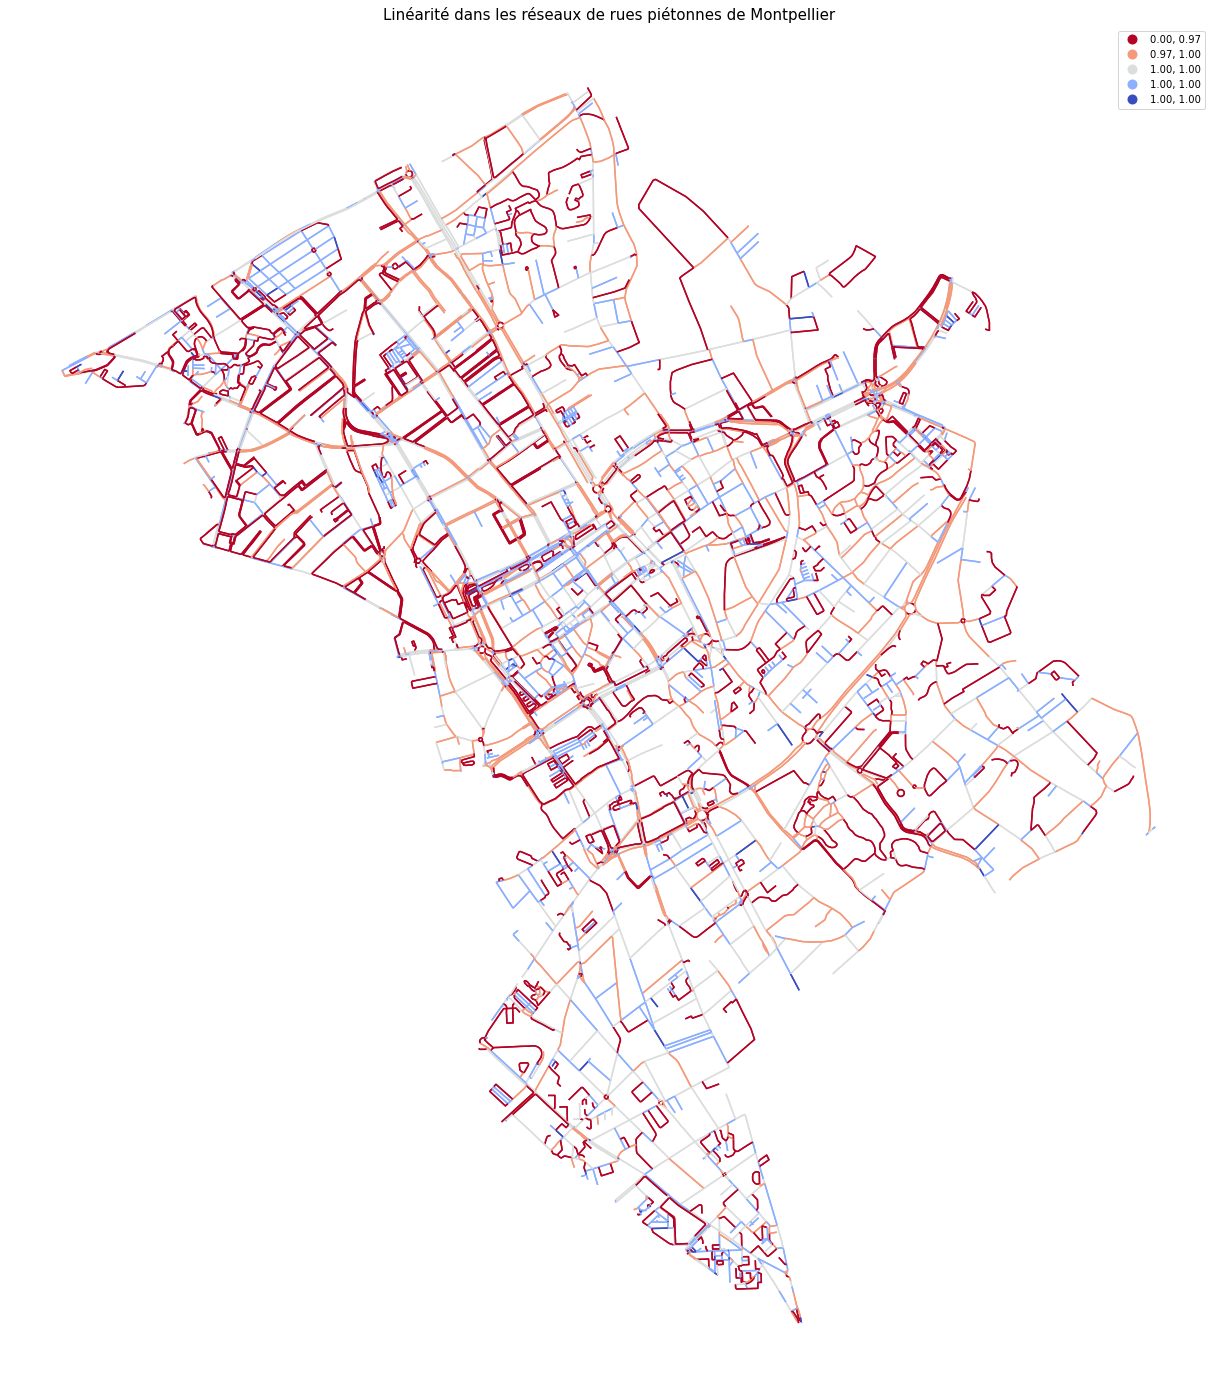

In [20]:
f, ax = plt.subplots(figsize=(25, 25))
edges.plot(ax=ax, column='linearity', legend=True, cmap='coolwarm_r', scheme='quantiles', k=6)
ax.set_axis_off()
ax.set_title("Linéarité dans les réseaux de rues piétonnes de Montpellier", fontsize=15)
plt.show()